# Understanding the relationships between macoreconomic variables across different countries

This notebook Will investigate the correlation and perform clustering techniques on IMF database (i.e. 196 countries)

Knowing that its time series data, its probably better to perform time series clustering instead of plain (regular) clustering. We will break down the data sets into 3 dfs, each for a target MEV.

GDP df:
* Correlation, and extract countries with highest corr with a target one
* Clustering
* PCA

The same will be applied to CPI and Unemployment Rate

In [2]:
!pip install dataprep > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.7.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


**Import Libraries**

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st



from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Libraries:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer


from dataprep.eda import create_report
from dataprep.eda import plot, plot_correlation, plot_missing

**Upload datasets**

In [4]:
mev = pd.read_excel('allCountries_IMF.xlsx')

In [5]:
mev.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,1092.12,1154.18,1185.31,1197.01,1222.92,1255.29,1270.22,1319.9,1253.91,1304.06
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,13.968,5.683,2.697,0.988,2.164,2.647,1.189,3.912,-5,4
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,1033.59,1116.83,1183.04,1226.57,1222.92,1285.46,1327.69,1469.6,1470.21,1599.35
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,20.293,20.17,20.635,20.22,17.994,18.91,18.401,18.876,19.132,19.938
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,59.945,63.784,69.444,72.056,70.098,74.712,77.416,81.88,78.729,83.37


**General cleaning**

In [6]:
mev.columns.values

array(['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
       'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
       'Country/Series-specific Notes', 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021], dtype=object)

In [7]:
df = pd.melt(mev, id_vars=['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
       'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
       'Country/Series-specific Notes'], var_name='year', value_name='mev_value')

In [8]:
df.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,year,mev_value
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,1980,NaN
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",1980,NaN
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,1980,NaN
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1980,NaN
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",1980,NaN


In [9]:
mev.shape, df.shape

((8777, 51), (368634, 11))

In [10]:
df.isnull().sum()

WEO Country Code                     42
ISO                                  84
WEO Subject Code                     84
Country                              84
Subject Descriptor                   84
Subject Notes                      8274
Units                                84
Scale                            204834
Country/Series-specific Notes     49518
year                                  0
mev_value                        104444
dtype: int64

In [11]:
df_comp = df.dropna(subset=['mev_value'])

In [12]:
df_comp.fillna('not_provide', inplace=True)

In [13]:
df_comp.isnull().sum()

WEO Country Code                 0
ISO                              0
WEO Subject Code                 0
Country                          0
Subject Descriptor               0
Subject Notes                    0
Units                            0
Scale                            0
Country/Series-specific Notes    0
year                             0
mev_value                        0
dtype: int64

In [14]:
df_comp.shape, df.shape

((264190, 11), (368634, 11))

**Replace long names of MEVs and keep only the ones we will use**
* GDP
* CPI (Inflation)
* Unemployment Rate

In [15]:
df_comp['Subject Descriptor'].value_counts()

Gross domestic product, current prices                                                22293
Gross domestic product per capita, current prices                                     22072
Gross domestic product, constant prices                                               14798
Inflation, average consumer prices                                                    14723
Gross domestic product per capita, constant prices                                    14697
Current account balance                                                               14132
Inflation, end of period consumer prices                                              13913
General government revenue                                                            11781
General government total expenditure                                                  11667
General government net lending/borrowing                                              11614
General government primary net lending/borrowing                                

In [16]:
def change_names(df):
  if df['Subject Descriptor'] == 'Gross domestic product, current prices' and df['Units'] == 'U.S. dollars':
    return 'GDP'
  elif df['Subject Descriptor'] == 'Inflation, end of period consumer prices':
    return 'Inflation, CPI'
  elif df['Subject Descriptor'] == 'Unemployment rate':
    return 'Unemployment rate'
  else:
    return 'Other'



df_comp['mev_name'] = df_comp.apply(change_names, axis=1)

In [17]:
df_smaller = df_comp[df_comp['mev_name'] != 'Other']
df_smaller.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,year,mev_value,mev_name
48,914,ALB,NGDPD,Albania,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1980,1.946,GDP
70,914,ALB,LUR,Albania,Unemployment rate,Unemployment rate can be defined by either the...,Percent of total labor force,not_provide,Source: National Statistics Office Latest actu...,1980,5.028,Unemployment rate
93,612,DZA,NGDPD,Algeria,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1980,42.346,GDP
108,612,DZA,PCPIE,Algeria,"Inflation, end of period consumer prices","Expressed in end of the period, not annual ave...",Index,not_provide,Source: National Statistics Office Latest actu...,1980,6.573,"Inflation, CPI"
109,612,DZA,PCPIEPCH,Algeria,"Inflation, end of period consumer prices",Annual percentages of end of period consumer p...,Percent change,not_provide,"See notes for: Inflation, end of period consu...",1980,14.143,"Inflation, CPI"


In [18]:
df_smaller.shape

(25218, 12)

In [19]:
df_smaller['mev_value'] = pd.to_numeric(df_smaller['mev_value'],errors = 'coerce')

df_smaller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25218 entries, 48 to 368606
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   WEO Country Code               25218 non-null  int64  
 1   ISO                            25218 non-null  object 
 2   WEO Subject Code               25218 non-null  object 
 3   Country                        25218 non-null  object 
 4   Subject Descriptor             25218 non-null  object 
 5   Subject Notes                  25218 non-null  object 
 6   Units                          25218 non-null  object 
 7   Scale                          25218 non-null  object 
 8   Country/Series-specific Notes  25218 non-null  object 
 9   year                           25218 non-null  int64  
 10  mev_value                      25177 non-null  float64
 11  mev_name                       25218 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory us

---
**Cleaning is done, High level EDA**



DataPrep Report
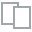
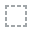
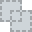
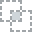
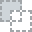
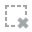
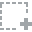
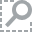
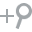
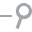
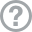
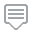
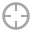
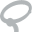
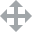
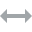
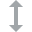
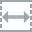
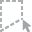
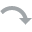
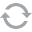
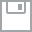
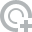
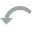
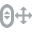
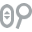
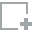
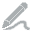
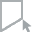
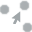
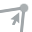
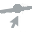

In [ ]:
create_report(df_smaller)

**Correlation**

In [20]:
def create_pivot(df, filter_mev='GDP' ,index='year', column='Country', value='mev_value'):
  df = df[df['mev_name']==filter_mev]
  df_piv = pd.pivot_table(data=df, index=index, columns=column,values=value, fill_value=0)

  return df_piv

In [21]:
# divide them into 3 dataframes

gdp_df = create_pivot(df_smaller, filter_mev='GDP')

unempRate_df = create_pivot(df_smaller, filter_mev='Inflation, CPI')

cpi_df =  create_pivot(df_smaller, filter_mev='Unemployment rate')


def corr_annot(x, y, ax=None, **kws):
    """Annotate a plot w/ the correlation coefficient."""
    r, _ = st.pearsonr(x, y)
    ax = ax or plt.gca()
    fontsizes = {range(0,21):"medium", range(21,51):'large', range(51,81):'x-large', range(90,101):'xx-large'}

    if r > 0:
        font_size = [fontsize for bound,fontsize in fontsizes.items() if round(abs(r), 1)*100 in bound][0]
        ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, fontsize = font_size)

In [22]:
gdp_df.head(2)

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1980,0.0,1.946,42.346,6.639,0.131,233.696,0.0,0.0,162.628,80.923,...,2857.33,12.165,0.0,0.121,69.841,35.357,0.0,0.0,4.246,0.0
1981,0.0,2.229,44.372,6.214,0.148,189.802,0.0,0.0,188.067,70.121,...,3207.03,13.578,0.0,0.114,78.367,17.617,0.0,0.0,4.385,0.0


In [23]:
corr = gdp_df.corr()
corr = corr.mask(corr.apply(lambda x: x.name == x.index))

high_correlated = corr.abs(
  ).unstack(
    ).drop_duplicates(
      ).where(lambda x:  x >= 0.9).dropna()



gdp_corr = pd.DataFrame(high_correlated)

gdp_corr = gdp_corr.reset_index(level=0)

gdp_corr.columns = ['Country2','Correlation']

gdp_corr = gdp_corr.reset_index()

In [24]:
gdp_corr[gdp_corr['Country']=='United States'].head()

,Country,Country2,Correlation
136,United States,Afghanistan,0.921159
293,United States,Albania,0.949082
561,United States,Antigua and Barbuda,0.977341
718,United States,Armenia,0.956752
773,United States,Aruba,0.927724


In [25]:
corr = unempRate_df.corr()
corr = corr.mask(corr.apply(lambda x: x.name == x.index))

um_correlated = corr.abs(
  ).unstack(
    ).drop_duplicates(
      ).where(lambda x:  x >= 0.9).dropna()



um_corr = pd.DataFrame(um_correlated)

um_corr = um_corr.reset_index(level=0)

um_corr.columns = ['Country2','Correlation']

um_corr = um_corr.reset_index()

In [26]:
um_corr[(um_corr['Country']=='Sweden') & (um_corr['Correlation']>0.98)].sort_values(by='Correlation', ascending=False)

,Country,Country2,Correlation
3000,Sweden,Hungary,0.989866
2476,Sweden,Finland,0.989780
2543,Sweden,France,0.989307
1996,Sweden,Denmark,0.988148
4018,Sweden,Morocco,0.987512
3237,Sweden,Italy,0.987334
1405,Sweden,Canada,0.987189
4591,Sweden,Spain,0.985896
4393,Sweden,Portugal,0.981949
4236,Sweden,Norway,0.981190


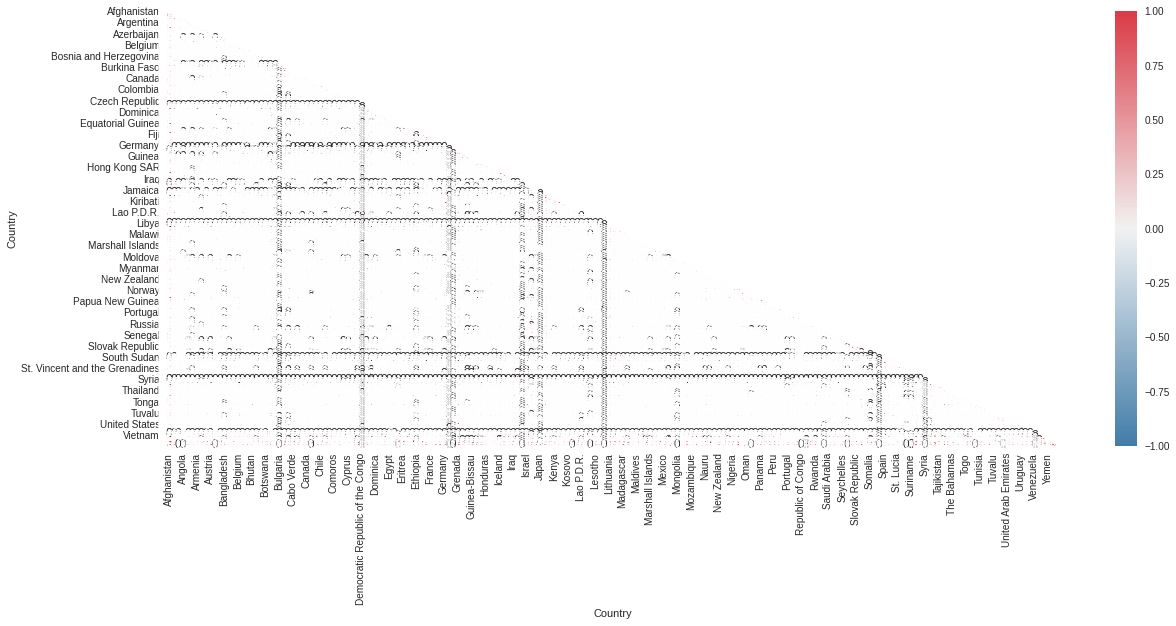

In [ ]:
corr = gdp_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(240, 10, as_cmap=True)

corr[abs(corr) <= 0.75] = 0

plt.figure(figsize=(20,8))
sns.heatmap(
    corr,
    mask = mask,
    vmin = -1,
    vmax = 1,
    cmap = cmap,
    annot = True
);

--------------------------------------------------
# Second Step Clustering
---------------------------------------------------

**After experimenting, we will need to transpose the df. we need to conver the countries to be the data points, instead of the years**

In [27]:
df_smaller.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,year,mev_value,mev_name
48,914,ALB,NGDPD,Albania,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1980,1.946,GDP
70,914,ALB,LUR,Albania,Unemployment rate,Unemployment rate can be defined by either the...,Percent of total labor force,not_provide,Source: National Statistics Office Latest actu...,1980,5.028,Unemployment rate
93,612,DZA,NGDPD,Algeria,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1980,42.346,GDP
108,612,DZA,PCPIE,Algeria,"Inflation, end of period consumer prices","Expressed in end of the period, not annual ave...",Index,not_provide,Source: National Statistics Office Latest actu...,1980,6.573,"Inflation, CPI"
109,612,DZA,PCPIEPCH,Algeria,"Inflation, end of period consumer prices",Annual percentages of end of period consumer p...,Percent change,not_provide,"See notes for: Inflation, end of period consu...",1980,14.143,"Inflation, CPI"


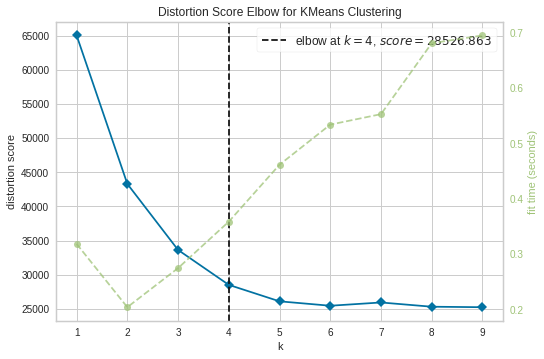

In [ ]:
# More fancy and viasually way to do the elbow method approach:

X = df_smaller[['Country','mev_name','mev_value']]


categorical_features = df_smaller[['Country','mev_name']].columns.tolist()


numeric_features =df_smaller[['mev_value']].columns.tolist()


categorical_transformer  = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

numeric_transformer = Pipeline(steps=[('Scaling', StandardScaler()),
                                       ("knn_imputer", KNNImputer(n_neighbors=5))])
 

feature_encoder = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                  ('cat',categorical_transformer,categorical_features)])

X = feature_encoder.fit_transform(X)

# Clustering model and visualizer:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(X) 
visualizer.poof() 

In [ ]:
feature_encoder

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('Scaling', StandardScaler()),
                                                 ('knn_imputer',
                                                  KNNImputer())]),
                                 ['mev_value']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Country', 'mev_name'])])

For n_clusters = 2 The average silhouette_score is : 0.945
For n_clusters = 3 The average silhouette_score is : 0.2354
For n_clusters = 4 The average silhouette_score is : 0.294
For n_clusters = 5 The average silhouette_score is : 0.2957
For n_clusters = 6 The average silhouette_score is : 0.1387
For n_clusters = 7 The average silhouette_score is : 0.1392
For n_clusters = 8 The average silhouette_score is : 0.1439
For n_clusters = 9 The average silhouette_score is : 0.1425


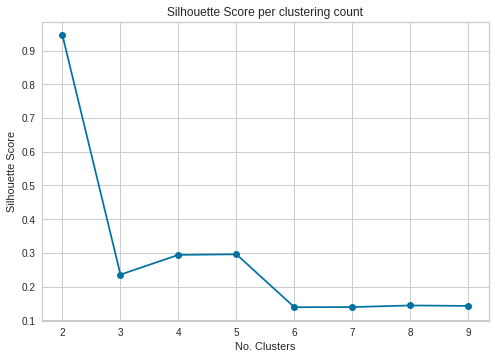

In [ ]:
#X = feature_encoder.fit_transform(X)
silhouette_s = []

for n_clusters in range(2, 10):
    cl_algo = KMeans(n_clusters=n_clusters)


    cluster_labels = cl_algo.fit_predict(X)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(X, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(X, cluster_labels))

plt.plot(range(2, 10),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per clustering count")
plt.show()

In [ ]:
n_clusters = 4
# kmeans_pipeline = Pipeline(
#     [
#         ("scaler", StandardScaler()),
#         ("cluster", KMeans(n_clusters=n_clusters, random_state=123, verbose=0)),
#     ]
# )

clusteringKmeans = KMeans(n_clusters=n_clusters, random_state=123)
clusteringKmeans.fit(X)
labels = clusteringKmeans.predict(X)
#centers = clusteringKmeans.named_steps["cluster"].cluster_centers_


df_smaller["clusters"] = labels
#sns.scatterplot(data=df_smaller, x="Canada_Nominal_GDP", y="Switzerland_Nominal_GDP", hue="k-means3",palette='bright');

df_smaller.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,year,mev_value,mev_name,clusters
48,914,ALB,NGDPD,Albania,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1980,1.946,GDP,0
70,914,ALB,LUR,Albania,Unemployment rate,Unemployment rate can be defined by either the...,Percent of total labor force,not_provide,Source: National Statistics Office Latest actu...,1980,5.028,Unemployment rate,3
93,612,DZA,NGDPD,Algeria,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",1980,42.346,GDP,0
108,612,DZA,PCPIE,Algeria,"Inflation, end of period consumer prices","Expressed in end of the period, not annual ave...",Index,not_provide,Source: National Statistics Office Latest actu...,1980,6.573,"Inflation, CPI",1
109,612,DZA,PCPIEPCH,Algeria,"Inflation, end of period consumer prices",Annual percentages of end of period consumer p...,Percent change,not_provide,"See notes for: Inflation, end of period consu...",1980,14.143,"Inflation, CPI",1


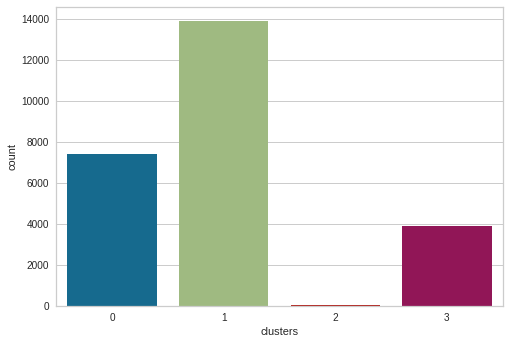

In [ ]:
sns.countplot(data=df_smaller, x='clusters');

**Separate Clustering based on MEV**

-----------------------------------------

## GDP

In [52]:
gdp_df.head(2)


Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1980,0.0,1.946,42.346,6.639,0.131,233.696,0.0,0.0,162.628,80.923,...,2857.33,12.165,0.0,0.121,69.841,35.357,0.0,0.0,4.246,0.0
1981,0.0,2.229,44.372,6.214,0.148,189.802,0.0,0.0,188.067,70.121,...,3207.03,13.578,0.0,0.114,78.367,17.617,0.0,0.0,4.385,0.0


In [78]:
gdp_df_t = gdp_df.T.reset_index()
gdp_df_t = gdp_df_t.set_index('Country')

gdp_X = gdp_df_t.values

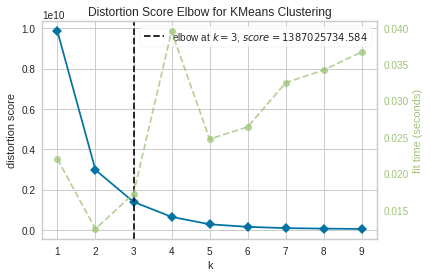

In [68]:
# Clustering model and visualizer:

#model = KMeans()
visualizer = KElbowVisualizer(kmeans_pipeline, k=(1,10))
visualizer.fit(gdp_X) 
visualizer.poof() 

For n_clusters = 2 The average silhouette_score is : 0.9579
For n_clusters = 3 The average silhouette_score is : 0.9129
For n_clusters = 4 The average silhouette_score is : 0.8815
For n_clusters = 5 The average silhouette_score is : 0.8661
For n_clusters = 6 The average silhouette_score is : 0.8349
For n_clusters = 7 The average silhouette_score is : 0.7409
For n_clusters = 8 The average silhouette_score is : 0.7386
For n_clusters = 9 The average silhouette_score is : 0.7136


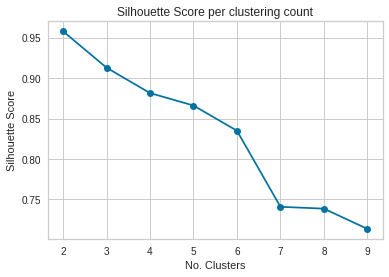

In [69]:
#X = feature_encoder.fit_transform(X)
silhouette_s = []

for n_clusters in range(2, 10):
    cl_algo = KMeans(n_clusters=n_clusters)


    cluster_labels = cl_algo.fit_predict(gdp_X)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(gdp_X, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(gdp_X, cluster_labels))

plt.plot(range(2, 10),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per clustering count")
plt.show()

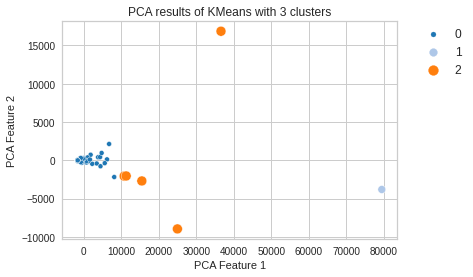

In [72]:
from sklearn.decomposition import PCA

# First calculate top two PCA features.
pca = PCA(n_components=2)
pca_features = pca.fit_transform(gdp_X)
x = pca_features[:,0]
y = pca_features[:,1]

K=3

kmeans = KMeans(n_clusters=K, random_state=42)
cl_labels = kmeans.fit_predict(gdp_X)
df_pca_features = pd.DataFrame({'cluster_id': cl_labels,
                                'pc_1':x,
                                'pc_2':y})
ax = sns.scatterplot(x='pc_1', y='pc_2',
                hue='cluster_id',
                size='cluster_id',
                data=df_pca_features,
                palette='tab20',
                legend='full')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('PCA results of KMeans with ' + str(K) + ' clusters')
ax.legend(bbox_to_anchor=(1.04,1.02), loc='upper left', fontsize='large');

## Unemployment Rate

----------------------------------------------

In [79]:
unempRate_df.head()

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1980,0.0,0.0,10.3580,0.000,29.9915,0.0,0.0,0.0,0.0,30.6385,...,49.3185,21.4205,0.0,27.7915,0.000,0.0,0.0,0.0,0.0080,0.0
1981,0.0,0.0,6.8205,1.833,26.2295,0.0,0.0,0.0,0.0,32.2610,...,51.3760,14.6940,0.0,36.9515,0.000,0.0,0.0,0.0,7.0030,0.0
1982,0.0,0.0,6.3140,1.833,24.5510,0.0,0.0,0.0,0.0,32.7940,...,50.9920,10.2825,0.0,22.7015,0.000,0.0,0.0,0.0,6.2530,0.0
1983,0.0,0.0,10.5040,1.833,25.5230,0.0,0.0,0.0,0.0,33.4750,...,52.8735,25.7800,0.0,26.8295,0.000,0.0,0.0,0.0,9.8525,0.0
1984,0.0,0.0,9.9305,1.833,26.3470,0.0,0.0,0.0,0.0,35.7015,...,54.8395,33.1035,0.0,26.7800,0.142,0.0,0.0,0.0,10.0170,0.0


In [80]:
unempRate_df_t = unempRate_df.T.reset_index()
unempRate_df_t = unempRate_df_t.set_index('Country')

unempRate_X = unempRate_df_t.values

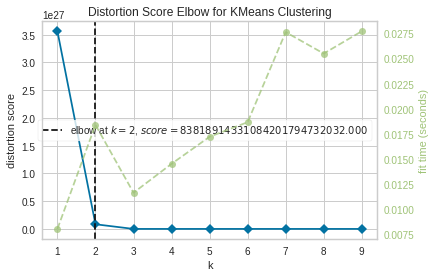

In [81]:
# Clustering model and visualizer:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(unempRate_X) 
visualizer.poof() 

For n_clusters = 2 The average silhouette_score is : 0.9932
For n_clusters = 3 The average silhouette_score is : 0.9897
For n_clusters = 4 The average silhouette_score is : 0.9846
For n_clusters = 5 The average silhouette_score is : 0.9564
For n_clusters = 6 The average silhouette_score is : 0.91
For n_clusters = 7 The average silhouette_score is : 0.875
For n_clusters = 8 The average silhouette_score is : 0.8824
For n_clusters = 9 The average silhouette_score is : 0.8486


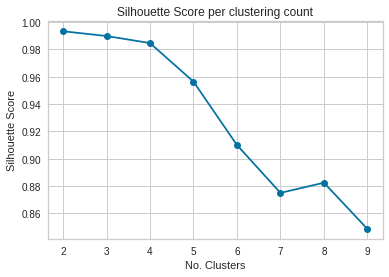

In [88]:
#X = feature_encoder.fit_transform(X)
silhouette_s = []

for n_clusters in range(2, 10):
    cl_algo = KMeans(n_clusters=n_clusters)


    cluster_labels = cl_algo.fit_predict(unempRate_X)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(unempRate_X, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(unempRate_X, cluster_labels))

plt.plot(range(2, 10),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per clustering count")
plt.show()

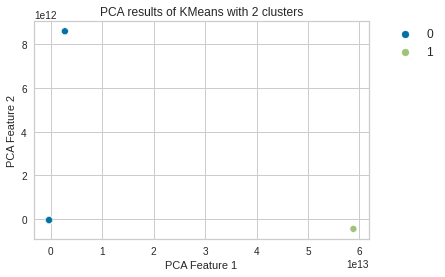

In [90]:
from sklearn.decomposition import PCA

# First calculate top two PCA features.
pca = PCA(n_components=2)
pca_features = pca.fit_transform(unempRate_X)
x = pca_features[:,0]
y = pca_features[:,1]

K=2

kmeans = KMeans(n_clusters=K, random_state=42)
cl_labels = kmeans.fit_predict(unempRate_X)
df_pca_features = pd.DataFrame({'cluster_id': cl_labels,
                                'pc_1':x,
                                'pc_2':y})
ax = sns.scatterplot(x='pc_1', y='pc_2',
                hue='cluster_id',
                #size='cluster_id',
                data=df_pca_features,
                #palette='tab20',
                legend='full')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('PCA results of KMeans with ' + str(K) + ' clusters')
ax.legend(bbox_to_anchor=(1.04,1.02), loc='upper left', fontsize='large');

## CPI

-----------------------------------------------------

In [91]:
cpi_df.head()

Country,Albania,Algeria,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahrain,Barbados,...,Trinidad and Tobago,Tunisia,Turkey,Ukraine,United Kingdom,United States,Uruguay,Venezuela,Vietnam,West Bank and Gaza
year,,,,,,,,,,,,,,,,,,,,,
1980,5.028,15.789,3.0,0.0,0.0,6.133,1.6,0.0,0.0,0.000,...,0.000,0.0,7.200,0.0,7.133,7.175,0.0,0.0,0.0,0.0
1981,4.224,15.385,5.0,0.0,0.0,5.783,2.2,0.0,0.0,10.760,...,10.408,0.0,7.200,0.0,9.650,7.617,0.0,0.0,0.0,0.0
1982,2.813,15.000,4.5,0.0,0.0,7.183,3.1,0.0,0.0,13.650,...,10.271,0.0,7.600,0.0,10.725,9.708,0.0,0.0,0.0,0.0
1983,3.335,14.286,5.0,0.0,0.0,9.967,3.7,0.0,0.0,14.945,...,11.123,0.0,7.510,0.0,11.475,9.600,14.5,0.0,0.0,0.0
1984,4.410,16.536,5.0,0.0,0.0,8.967,3.8,0.0,0.0,17.037,...,13.428,0.0,7.407,0.0,11.750,7.508,14.0,0.0,0.0,0.0


In [92]:
cpi_df_t = cpi_df.T.reset_index()
cpi_df_t = cpi_df_t.set_index('Country')

cpi_X = cpi_df_t.values

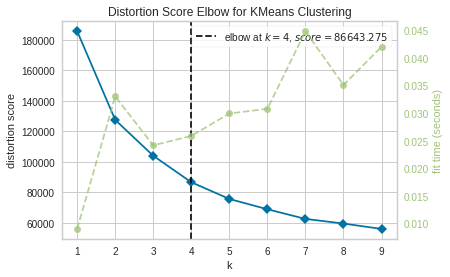

In [93]:
# Clustering model and visualizer:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(cpi_X) 
visualizer.poof() 

For n_clusters = 2 The average silhouette_score is : 0.3698
For n_clusters = 3 The average silhouette_score is : 0.3046
For n_clusters = 4 The average silhouette_score is : 0.2594
For n_clusters = 5 The average silhouette_score is : 0.2415
For n_clusters = 6 The average silhouette_score is : 0.194
For n_clusters = 7 The average silhouette_score is : 0.2125
For n_clusters = 8 The average silhouette_score is : 0.224
For n_clusters = 9 The average silhouette_score is : 0.2079


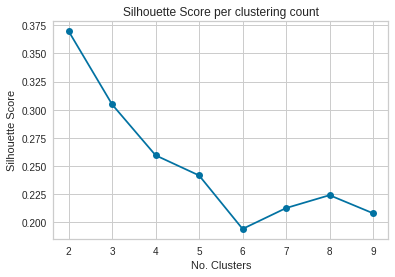

In [94]:
#X = feature_encoder.fit_transform(X)
silhouette_s = []

for n_clusters in range(2, 10):
    cl_algo = KMeans(n_clusters=n_clusters)


    cluster_labels = cl_algo.fit_predict(cpi_X)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(cpi_X, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(cpi_X, cluster_labels))

plt.plot(range(2, 10),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per clustering count")
plt.show()

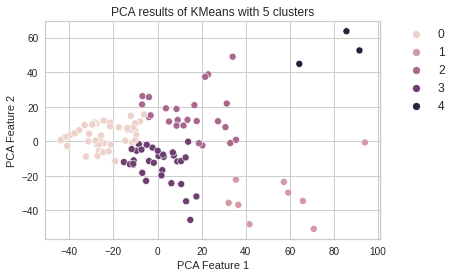

In [95]:
from sklearn.decomposition import PCA

# First calculate top two PCA features.
pca = PCA(n_components=2)
pca_features = pca.fit_transform(cpi_X)
x = pca_features[:,0]
y = pca_features[:,1]

K=5

kmeans = KMeans(n_clusters=K, random_state=42)
cl_labels = kmeans.fit_predict(cpi_X)
df_pca_features = pd.DataFrame({'cluster_id': cl_labels,
                                'pc_1':x,
                                'pc_2':y})
ax = sns.scatterplot(x='pc_1', y='pc_2',
                hue='cluster_id',
                #size='cluster_id',
                data=df_pca_features,
                #palette='tab20',
                legend='full')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('PCA results of KMeans with ' + str(K) + ' clusters')
ax.legend(bbox_to_anchor=(1.04,1.02), loc='upper left', fontsize='large');

#End